<a href="https://colab.research.google.com/github/vortexash/Tensorflow-Developer/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about new kind of transfer learning: fine-tuning

In [1]:
# Check if we're using a GPU
!nvidia-smi

Sun Oct 17 16:09:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebook we've create a bunch of helper functions, now we could rewrite them all,however,this is tedious.

So, it's a good idea to put functions we'll want to use again in ascript we can download and import into our notebooks(or elsewhere).

We've done this for some of the functions we've using previously https://raw.githubusercontent.com/vortexash/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/vortexash/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-17 16:09:29--  https://raw.githubusercontent.com/vortexash/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-17 16:09:29 (68.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper function we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

**Note:** If we're running this notebook in google colab, when it times out colab will delete `helper_functions.py`, so you'll have to re-download it if we want to access ti our helper functions.

## Let's get some data

This time we're are going to see how we can use the pre-trained models within tf.keras.applications and apply then to our own problem (recognizing images of food).

link:https://www.tensorflow.org/api_docs/python/tf/keras/applications


In [4]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
unzip_data("10_food_classes_10_percent.zip")

--2021-10-17 16:09:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.167.128, 74.125.71.128, 74.125.133.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  55.8MB/s    in 2.9s    

2021-10-17 16:09:35 (55.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and sub-directories are in our dataset
walk_through_dir("/content/10_food_classes_10_percent")

There are 2 directories and 0 images in '/content/10_food_classes_10_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '/content/10_food_classes_10_

In [6]:
# Create and training and test directory paths
train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [7]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                           image_size = IMG_SIZE,
                                                                           label_mode = 'categorical',
                                                                           batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                               image_size = IMG_SIZE,
                                                               label_mode = 'categorical',
                                                               batch_size = BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [9]:
# Check out the class names of the dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# Seeing an example of a batch of data
for images,labels in train_data_10_percent.take(1):
  print(images,labels)


tf.Tensor(
[[[[2.19841827e+02 1.08841835e+02 1.17841835e+02]
   [2.23168365e+02 1.13168365e+02 1.22168365e+02]
   [2.19785721e+02 1.10428574e+02 1.21214287e+02]
   ...
   [2.27285721e+02 2.23285721e+02 2.24285721e+02]
   [2.26642853e+02 2.22642853e+02 2.23642853e+02]
   [2.26642853e+02 2.22642853e+02 2.23642853e+02]]

  [[2.23091843e+02 1.11091835e+02 1.23091835e+02]
   [2.26642868e+02 1.14642853e+02 1.26642853e+02]
   [2.20173462e+02 1.10602036e+02 1.22030609e+02]
   ...
   [2.26086731e+02 2.22086731e+02 2.23086731e+02]
   [2.25137756e+02 2.21137756e+02 2.22137756e+02]
   [2.24142853e+02 2.20142853e+02 2.21142853e+02]]

  [[2.21576523e+02 1.06576530e+02 1.21576530e+02]
   [2.21387756e+02 1.09341835e+02 1.23357140e+02]
   [2.21000000e+02 1.11000000e+02 1.24000000e+02]
   ...
   [2.26214279e+02 2.19571426e+02 2.19785721e+02]
   [2.26443878e+02 2.19801025e+02 2.20015305e+02]
   [2.26642853e+02 2.20000000e+02 2.20214279e+02]]

  ...

  [[2.38928619e+02 2.17357147e+02 2.19142883e+02]
   [2

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it euns layers in sequential order.

But the functional API gives more flexibility with our models.
https://www.tensorflow.org/guide/keras/functional

In [13]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained  aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using model like ResNet50v2 we will need to normalize inputs(you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)

# 5. Pass the input to the base_model
x = base_model(inputs)
print(f" Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = "gobal_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape} ")

# 7. Create the output  activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics = ['accuracy'])
# 10. Fit our model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                  epochs=5, 
                                  steps_per_epoch =len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps= int(0.25 * len(test_data)),
                                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                          experiment_name="10_percent_feature_extraction")])

 Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280) 
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20211017-170256
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 44s 376ms/step - loss: 1.7860 - accuracy: 0.4800 - val_loss: 1.2449 - val_accuracy: 0.7484
Epoch 2/5
24/24 [==============================] - 7s 267ms/step - loss: 1.0888 - accuracy: 0.7493 - val_loss: 0.8817 - val_accuracy: 0.8026
Epoch 3/5
24/24 [==============================] - 7s 265ms/step - loss: 0.8099 - accuracy: 0.8027 - val_loss: 0.7087 - val_accuracy: 0.8405
Epoch 4/5
24/24 [==============================] - 7s 267ms/step - loss: 0.6761 - accuracy: 0.8280 - val_loss: 0.6512 - val_accuracy: 0.8224
Epoch 5/5
24/24 [==============================] - 7s 265ms/step - loss: 0.5769 - accuracy: 0.8627 - val_loss: 0.5743 - val_accuracy: 0.8454


In [14]:
# Evaluate on the ful test data
model_0.evaluate(test_data)

79/79 [==============================] - 11s 135ms/step - loss: 0.6015 - accuracy: 0.8348


[0.6014809012413025, 0.8348000049591064]

In [15]:
# Check the layers in out base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_2
1 rescaling_1
2 normalization_1
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [16]:
# How about we get summary of base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, None, None, 3 7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_1[0][0]            
_____________________________________________________________________________________

In [17]:
# How about a summary of our model
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
gobal_average_pooling_layer  (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


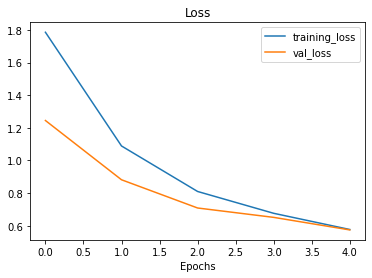

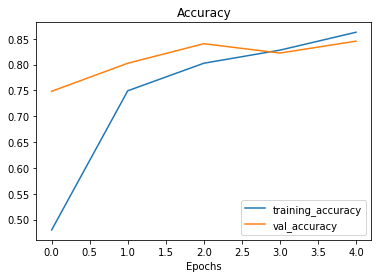

In [18]:
# Check out our model's training curve
plot_loss_curves(history_10_percent)